Dataset shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Target distribution:
y
no     39922
yes     5289
Name: count, dtype: int64


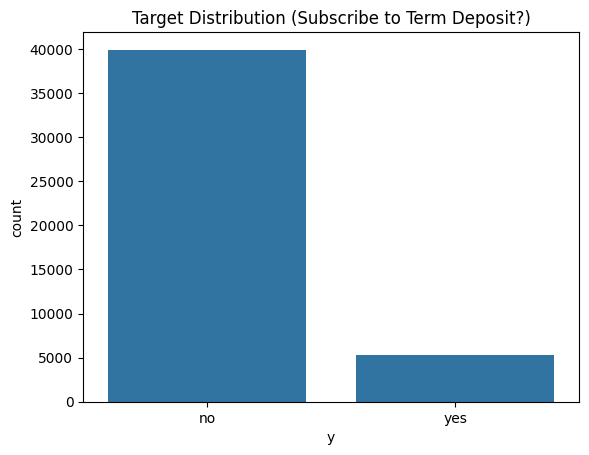

Numeric features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

--- Logistic Regression Results ---
Best Params: {'clf__C': 10, 'clf__solver': 'lbfgs'}
Accuracy: 0.8470640274245272
              precision    recall  f1-score   support

          no       0.97      0.85      0.91      7985
         yes       0.42      0.80      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043



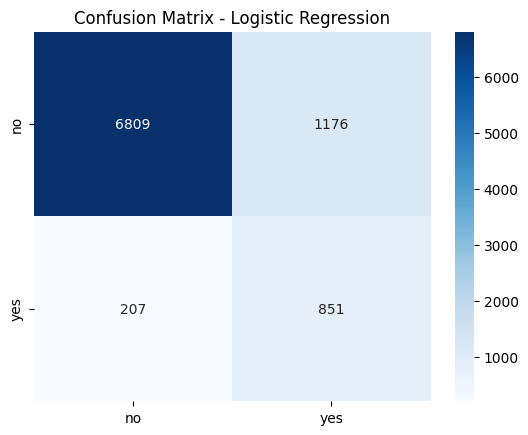


--- KNN Results ---
Best Params: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Accuracy: 0.8561318146632755
              precision    recall  f1-score   support

          no       0.95      0.88      0.92      7985
         yes       0.43      0.67      0.52      1058

    accuracy                           0.86      9043
   macro avg       0.69      0.77      0.72      9043
weighted avg       0.89      0.86      0.87      9043



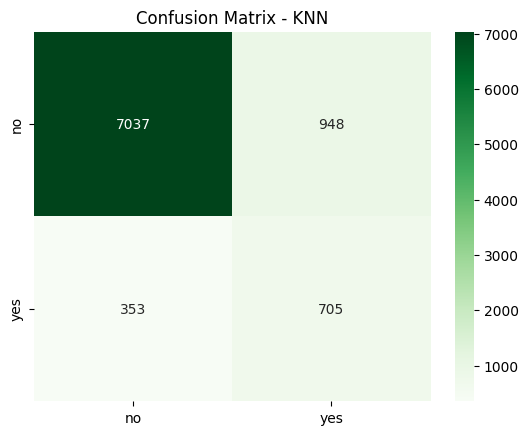

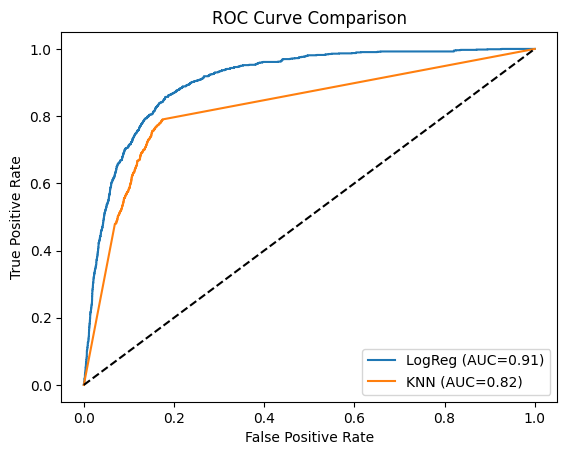

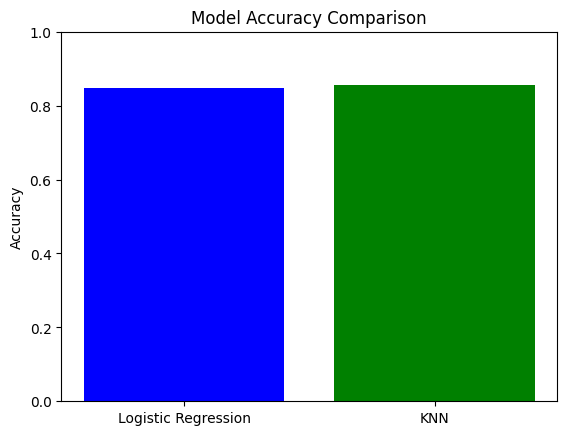


Final Comparison:
Logistic Regression Accuracy: 0.8471
KNN Accuracy: 0.8561


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # imbalanced-learn pipeline

# 1. Load dataset from LOCAL file
file_path = "/content/bank-full.csv"   # change if your file is elsewhere
df = pd.read_csv(file_path, sep=';')

print("Dataset shape:", df.shape)
print(df.head())

# 2. Basic Exploration
print("\nTarget distribution:")
print(df['y'].value_counts())

sns.countplot(x='y', data=df)
plt.title("Target Distribution (Subscribe to Term Deposit?)")
plt.show()

# 3. Preprocessing
X = df.drop('y', axis=1)
y = df['y']

numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 4. Logistic Regression with SMOTE + GridSearchCV
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

pipe_lr = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("\n--- Logistic Regression Results ---")
print("Best Params:", grid_lr.best_params_)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", acc_lr)
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_lr.classes_,
            yticklabels=best_lr.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 5. KNN with SMOTE + GridSearchCV
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance']
}

pipe_knn = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier())
])

grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("\n--- KNN Results ---")
print("Best Params:", grid_knn.best_params_)
acc_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", acc_knn)
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens",
            xticklabels=best_knn.classes_,
            yticklabels=best_knn.classes_)
plt.title("Confusion Matrix - KNN")
plt.show()

# 6. ROC Curve Comparison
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)  # convert 'yes'/'no' to 0/1

y_prob_lr = best_lr.predict_proba(X_test)[:,1]
y_prob_knn = best_knn.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test_enc, y_prob_lr)
fpr_knn, tpr_knn, _ = roc_curve(y_test_enc, y_prob_knn)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_score(y_test_enc, y_prob_lr):.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={roc_auc_score(y_test_enc, y_prob_knn):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# 7. Final Accuracy Comparison
plt.bar(['Logistic Regression','KNN'], [acc_lr, acc_knn], color=['blue','green'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

print("\nFinal Comparison:")
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"KNN Accuracy: {acc_knn:.4f}")
